In [2]:
import networkx as nx
from node2vec import Node2Vec
from igraph import Graph
import igraph as ig
import numpy as np
import json
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn.models.autoencoder import ARGA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.metrics import precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import neptune
import os

In [3]:
node_list_path = r'C:\Users\George\Desktop\ISEF-2023\Datas\Node list\back up\current_protein_Signal+meta+targets.json'
with open(node_list_path, 'r') as file:
    node_list = json.load(file)
graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

features = torch.tensor([
    PPI_graph.vs[key] for key in feature_keys
], dtype=torch.float).t()

edge_indices = torch.tensor(PPI_graph.get_edgelist(), dtype=torch.long).t()

# Assuming you have a label attribute in your graph
labels = torch.tensor(PPI_graph.vs["label"], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_indices, y=labels)

print(data)

Data(x=[7392, 26], edge_index=[2, 49502], y=[7392])


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)


In [4]:

data = train_test_split_edges(data)
print(data)

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[7392, 26], y=[7392], val_pos_edge_index=[2, 1237], test_pos_edge_index=[2, 2474], train_pos_edge_index=[2, 42062], train_neg_adj_mask=[7392, 7392], val_neg_edge_index=[2, 1237], test_neg_edge_index=[2, 2474])


In [5]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(GCNEncoder, self).__init__()

        self.convs = torch.nn.ModuleList()

        # Add the input layer
        self.convs.append(GCNConv(in_channels, layer_channels[0], cached=True))

        # Add hidden layers
        for i in range(1, len(layer_channels)):
            self.convs.append(GCNConv(layer_channels[i-1], layer_channels[i], cached=True))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index).relu()
        return self.convs[-1](x, edge_index)
    

In [6]:
run = neptune.init_run(
    project="georgewang2008/ARGA",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjU3MjQyMy0yZWUzLTQzNGYtOTI3MS0zNDNlYjJhOWQ3ZTgifQ==",
)

num_features = 26
epochs = 400
layer_channels = [32, 64, 64, 64, 128]  # List of channel sizes for each layer
lr = 0.001

param = {
    'num_features':num_features,
    'epochs':epochs,
    'layer_channels':str(layer_channels),  # List of channel sizes for each layer
    'lr':lr
}
run["parameters"] = param

# model
model = GAE(GCNEncoder(in_channels=num_features, layer_channels=layer_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/georgewang2008/ARGA/e/ARGA-19


In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [8]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

    run["train/loss"].append(loss)
    run["train/auc"].append(auc)
    run["train/ap"].append(ap)
    run["train/epoch"].append(epoch)

    if auc > 91 and ap > 91.1:
        break

Epoch: 001, AUC: 0.5384, AP: 0.5200
Epoch: 002, AUC: 0.5407, AP: 0.5212
Epoch: 003, AUC: 0.5421, AP: 0.5220
Epoch: 004, AUC: 0.5439, AP: 0.5230
Epoch: 005, AUC: 0.5541, AP: 0.5287
Epoch: 006, AUC: 0.5787, AP: 0.5430
Epoch: 007, AUC: 0.6060, AP: 0.5600
Epoch: 008, AUC: 0.6358, AP: 0.5798
Epoch: 009, AUC: 0.6681, AP: 0.6028
Epoch: 010, AUC: 0.6965, AP: 0.6246
Epoch: 011, AUC: 0.7183, AP: 0.6427
Epoch: 012, AUC: 0.7265, AP: 0.6498
Epoch: 013, AUC: 0.7280, AP: 0.6512
Epoch: 014, AUC: 0.7284, AP: 0.6515
Epoch: 015, AUC: 0.7279, AP: 0.6512
Epoch: 016, AUC: 0.7276, AP: 0.6508
Epoch: 017, AUC: 0.7274, AP: 0.6506
Epoch: 018, AUC: 0.7274, AP: 0.6506
Epoch: 019, AUC: 0.7274, AP: 0.6506
Epoch: 020, AUC: 0.7274, AP: 0.6506
Epoch: 021, AUC: 0.7272, AP: 0.6505
Epoch: 022, AUC: 0.7274, AP: 0.6506
Epoch: 023, AUC: 0.7274, AP: 0.6506
Epoch: 024, AUC: 0.7276, AP: 0.6508
Epoch: 025, AUC: 0.7278, AP: 0.6510
Epoch: 026, AUC: 0.7284, AP: 0.6515
Epoch: 027, AUC: 0.7284, AP: 0.6515
Epoch: 028, AUC: 0.7284, AP:

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


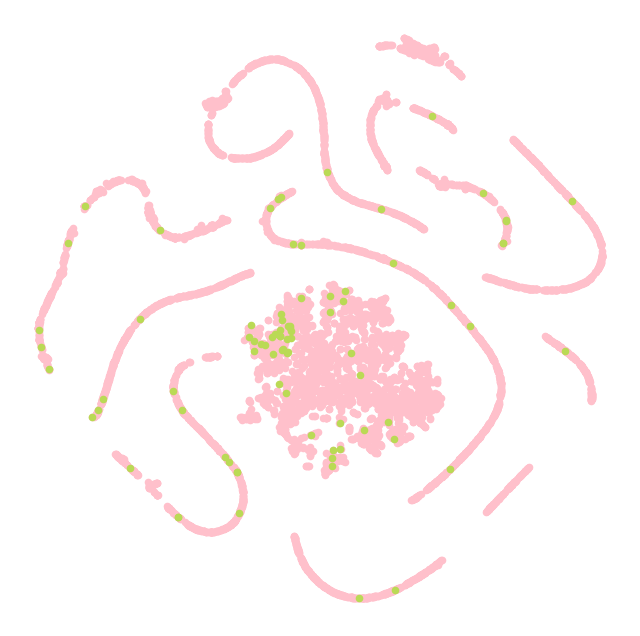

In [9]:
def plot_points(colors, save_path):
    model.eval()
    z = model.encode(x, train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.detach().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(2):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    
    plt.savefig(save_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
    plt.show()

colors = [
    '#ffc0cb', '#bada55'
]
plot_points(colors, r'C:\Users\George\Desktop\ISEF-2023\Model\test\GAE_PPI\embedded_plot.png')

In [10]:
Z = model.encode(x, train_pos_edge_index)
Z

tensor([[-1.5144e+02, -4.8213e+01,  7.0739e+01,  ..., -6.0621e+01,
         -1.7155e+02,  2.5294e+02],
        [ 2.8759e-04,  1.5775e-03,  1.9039e-03,  ...,  5.9857e-03,
          1.3888e-02, -2.0619e-02],
        [-9.2503e+01, -2.9408e+01,  4.3183e+01,  ..., -3.7078e+01,
         -1.0479e+02,  1.5443e+02],
        ...,
        [-2.2306e-03, -5.9313e-03,  2.3995e-03,  ..., -1.3298e-02,
         -2.1004e-02, -4.6236e-03],
        [-1.8984e+02, -6.0383e+01,  8.8570e+01,  ..., -7.6020e+01,
         -2.1506e+02,  3.1713e+02],
        [-1.4004e+02, -4.4592e+01,  6.5358e+01,  ..., -5.6099e+01,
         -1.5864e+02,  2.3393e+02]], grad_fn=<AddBackward0>)

In [11]:
import csv
node_names = PPI_graph.vs["name"]
csv_data = [["NodeName"] + [f"Feature_{i}" for i in range(Z.shape[1])]]

for name, embedding in zip(node_names, Z):
    row = [name] + embedding.tolist()
    csv_data.append(row)

print(csv_data)

csv_file_path = r"C:\Users\George\Desktop\ISEF-2023\Model\test\GAE_PPI\embed_38.csv"

# Write the CSV file
with open(csv_file_path, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(csv_data)

print(f"CSV file saved at: {csv_file_path}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CSV file saved at: C:\Users\George\Desktop\ISEF-2023\Model\test\GAE_PPI\embed_38.csv
